In [1]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN


%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
if False: #This vlock is from betas sweep. good betas. Not optimal.
    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_0_'
    timescampstrs={'07-14-29','09-46-07','14-35-38','13-49-42','09-45-53'} #they located in above or below
    #            curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]



if True:#This block is from tests done with all default (pytorch) parameters


    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
    timescampstrs = [
    "44_00-31-12",
    "47_00-31-10",
    "43_18-10-40",
    "46_18-10-39",
    "41_18-10-04",
    "49_18-00-09",
    "48_11-52-40",
    "45_11-50-38",
    "42_11-50-21",
    "40_11-49-46",
    "25_8-6-24",
    "24_01-54-27",
    "9_21-43-17",
    "4_21-42-58",
    "23_17-55-08",
    "29_15-29-37",
    "39_15-11-34",
    "34_15-09-31",
    "8_13-43-00",
    "3_13-42-41",
    "22_09-55-47",
    "38_08-50-47",
    "33_08-47-54",
    "28_08-46-30",
    "7_05-43-01",
    "2_05-42-47",
    "37_02-29-47",
    "32_2-26-51",
    "27_2-25-22",
    "21_01-56-27",
    "6_21-43-02",
    "1_21-42-47",
    "36_20-08-25",
    "31_20-05-29",
    "26_20-04-14",
    "20_17-57-14",
    "35_13-47-33",
    "30_13-44-32",
    "5_13-43-10",
    "0_13-42-53",
    "19_11-58-46",
    "18_8-27-31",
    "17_5-3-27",
    "16_01-39-09",
    "15_22-14-51",
    "14_17-34-09",
    "13_12-36-21",
    "12_9-12-21",
    "11_05-47-25",
    "10_1-9-58"
]

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'


decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        #print(medium_hat.shape)
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)


col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break


(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)


shape of the union without removin: (11552, 806)


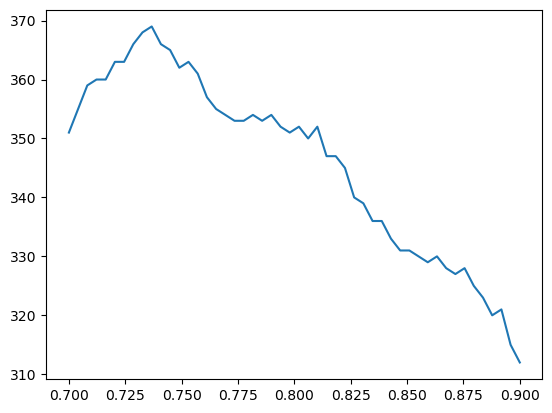

In [13]:
col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}')
size_list=[]
eps_lin=np.linspace(.7,.9,50)
for eps in eps_lin:
    intersection=[]
    intersection.append(col_list[0])

    for i in range(len(col_list)):
        in_flag=False
        repeated_flag=False
        for j in range(i+19*19,len(col_list)):
            j=j%(19*19)
            if abs(np.inner(col_list[i],col_list[j].conj()))>eps and i!=j:
                repeated_flag=True
                break
            else:
                repeated_flag=False
        for j in range(len(intersection)):
            if abs(np.inner(col_list[i],intersection[j].conj()))>eps:
                in_flag=True
                break
            else:
                in_flag=False
        if repeated_flag and (not in_flag):
            intersection.append(col_list[i])
    size_list.append(len(intersection))
        
plt.plot(eps_lin,size_list)

In [18]:
#eps_lin=np.linspace(.75,.95,4)
#print(size_list[0])
#plt.plot(eps_lin,size_list)
361 in size_list
indexOf=size_list.index(361)
print(eps_lin[indexOf])
size_list[indexOf],size_list[indexOf-1],size_list[indexOf+1]


0.7571428571428571


(361, 363, 357)

shape of the union with removin: (360, 806)


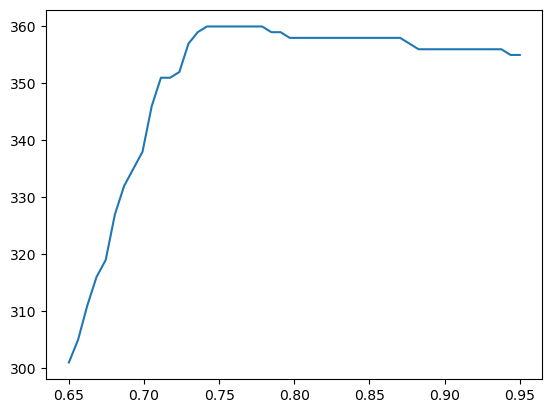

In [6]:
col_list=get_cluster_data(decoder_locats)
#print(f'shape of the union without removin: {col_list.shape}')
size_list=[]
for eps in np.linspace(.65,.95,50):
    intersection=[]
    intersection.append(col_list[0])

    for i in range(len(col_list)):
        in_flag=False
        repeated_flag=False
        for j in range(i+19*19,len(col_list)):
            j=j%(19*19)
            if abs(np.inner(col_list[i],col_list[j].conj()))>eps and i!=j:
                repeated_flag=True
                break
            else:
                repeated_flag=False
        for j in range(len(intersection)):
            if abs(np.inner(col_list[i],intersection[j].conj()))>eps:
                in_flag=True
                break
            else:
                in_flag=False
        if repeated_flag and (not in_flag):
            intersection.append(col_list[i])
    size_list.append(len(intersection))
        
plt.plot(np.linspace(.65,.95,50),size_list)
#print(f'shape of the union with removin: {len(intersection)}')
#print(f'avg max: {np.mean(max_inners)}, min max: {np.min(max_inners)}, num>.99: {len(max_inners[max_inners>.99])}')
#for i in range(len(torch_inners)):

 #   torch_inners[i]=torch_inners[i]/np.max(torch_inners[i])
for eps in [.75]:
    intersection=[]
    intersection.append(col_list[0])

    for i in range(len(col_list)):
        in_flag=False
        repeated_flag=False
        for j in range(i+19*19,len(col_list)):
            j=j%(19*19)
            if abs(np.inner(col_list[i],col_list[j].conj()))>eps and i!=j:
                repeated_flag=True
                break
            else:
                repeated_flag=False
        for j in range(len(intersection)):
            if abs(np.inner(col_list[i],intersection[j].conj()))>eps:
                in_flag=True
                break
            else:
                in_flag=False
        if repeated_flag and (not in_flag):
            intersection.append(col_list[i])

intersection=np.array(intersection)
print(f'shape of the union with removin: {intersection.shape}')

In [31]:
medium_hat=intersection
print(medium_hat[0].shape, sum(abs(medium_hat[0]**2)))
#medium_hat=F.normalize(medium_hat, dim=-1)
#medium_hat=medium_hat.cpu().detach().numpy()
#medium_hat=H.cat2complex(medium_hat)                    
torch_inners=[np.max(np.abs(np.inner(medium_hat,medium.T.conj()[i]) )) for i in range(361)] #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
torch_inners=np.array(torch_inners)
len(torch_inners)
np.mean(torch_inners)
len(torch_inners[torch_inners>.99])
#index_list=[]
#for i in range(int(outdim*2)):
#    if max(torch_inners[:, i])>.99 and i not in index_list:
#        index_list.append(i)
#    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
#max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
#len(index_list), max_avg_inners_original


(806,) 1.0000001597950359


351

In [19]:
medium.shape, medium_hat.shape

((806, 361), (360, 403))

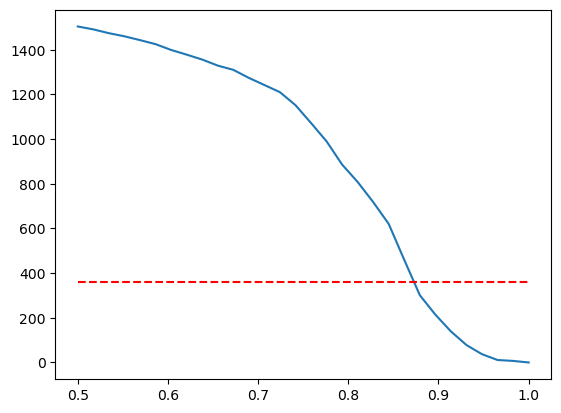

: 

In [19]:
X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
num_clusters=[]
eps_linspace=np.linspace(.5,1.0,30)
for eps in eps_linspace:
    DBSCAN_fit=DBSCAN(eps=eps, min_samples=2).fit(X)
    DBSCAN_fit.labels_
    X_clustered=X[DBSCAN_fit.labels_!=-1]
    len(X_clustered)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    dist_in_cluster=[]
    for i in range(max(DBSCAN_fit.labels_)):
        X_in_cluster=X[DBSCAN_fit.labels_==i]
        dist_matrix=distance_matrix(X_in_cluster, X_in_cluster)
        max_dist_in_cluster=np.max(dist_matrix)
        #dist=sum((X_in_cluster[0]-X_in_cluster[1])**2)**(1/2)
        dist_in_cluster.append(max_dist_in_cluster)
    # if len(X[DBSCAN_fit.labels_==i])>1:
    #     dist_in_cluster.append(np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1))
    # else:
    #     dist_in_cluster.append(0)
    dist_in_cluster#=[np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1)) for i in range(max(DBSCAN_fit.labels_))]
    dist_in_cluster.sort()
    #plt.plot([i for i in range(len(dist_in_cluster))], dist_in_cluster)
    num_clusters.append(len(cluster_sizes))
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
plt.plot(eps_linspace, num_clusters, label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[0],eps_linspace[-1], colors='r', linestyles='dashed', label='True number of columns')

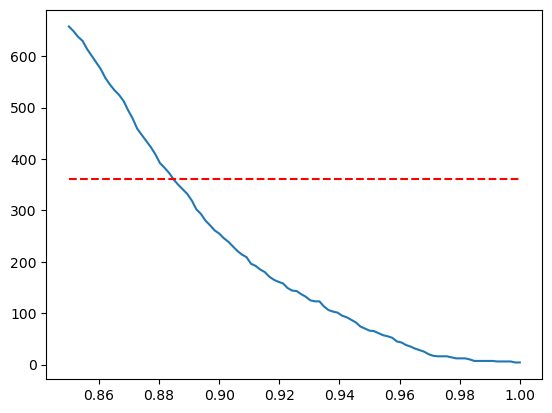

In [58]:
eps_linspace=np.linspace(.85,1.0,100)

plt.plot(eps_linspace, num_clusters, label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[0],eps_linspace[-1], colors='r', linestyles='dashed', label='True number of columns')

In [45]:
len(cluster_sizes)

841

In [82]:
medium_hat=np.array(intersection)
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=1)

max_inners_2=[max(torch_inners[:,i]) for i in range(torch_inners.shape[1])]
max_inners_2=np.array(max_inners_2)
max_inners_2[0],max_inners[0],torch_inners.shape


(0.9932644788601694, 0.9932644788601694, (361, 361))

In [77]:
index_list=[]
sum_max_inner_original=0
max_list=[]
for i in range(361):
    max_list.append(max(torch_inners[:, i]))
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
max_avg_inners_original=sum_max_inner_original/361

min(max_inners),max_avg_inners_original,len(index_list),min(max_list)

(0.9816059730577933, 0.9073889432874437, 273, 0.5285633787271118)

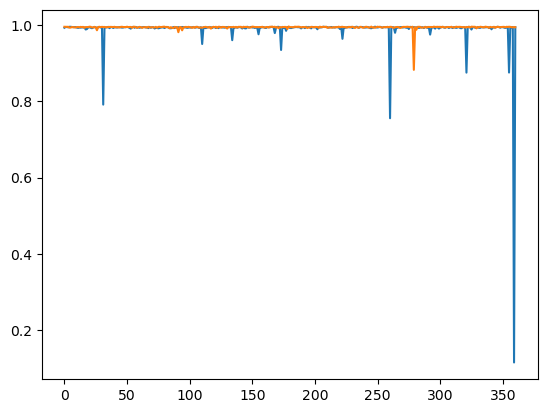

In [12]:
def get_max(medium_hat):
    sum_max_inner_original=0
    medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max over hats
    return np.max(torch_inners, axis=1)
best_decs=col_list[:19*19]
second_best_decs=col_list[19*19:19*19+19*19]
intersection=[]
d1_max=get_max(best_decs)
d2_max=get_max(second_best_decs)

plt.plot(d1_max)
plt.plot(d2_max)


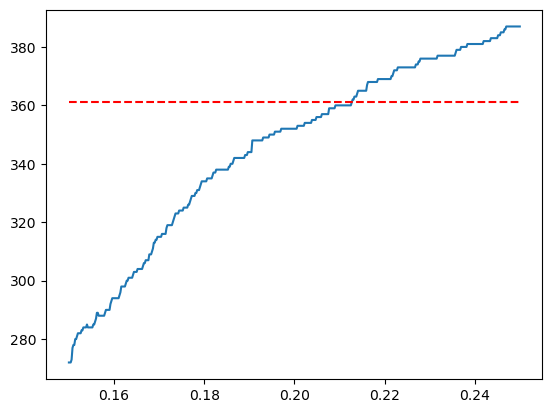

In [92]:
X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
num_clusters=[]
for eps in np.linspace(.15,.25,500):
    DBSCAN_fit=DBSCAN(eps=eps, min_samples=2).fit(X)
    DBSCAN_fit.labels_
    X_clustered=X[DBSCAN_fit.labels_!=-1]
    len(X_clustered)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    dist_in_cluster=[]
    for i in range(max(DBSCAN_fit.labels_)):
        X_in_cluster=X[DBSCAN_fit.labels_==i]
        dist_matrix=distance_matrix(X_in_cluster, X_in_cluster)
        max_dist_in_cluster=np.max(dist_matrix)
        #dist=sum((X_in_cluster[0]-X_in_cluster[1])**2)**(1/2)
        dist_in_cluster.append(max_dist_in_cluster)
    # if len(X[DBSCAN_fit.labels_==i])>1:
    #     dist_in_cluster.append(np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1))
    # else:
    #     dist_in_cluster.append(0)
    dist_in_cluster#=[np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1)) for i in range(max(DBSCAN_fit.labels_))]
    dist_in_cluster.sort()
    #plt.plot([i for i in range(len(dist_in_cluster))], dist_in_cluster)
    num_clusters.append(len(cluster_sizes))
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
plt.plot(np.linspace(.15,.25,500), num_clusters, label='DBSCAN number of clusters')
plt.hlines(19**2, .15,.25, colors='r', linestyles='dashed', label='True number of columns')

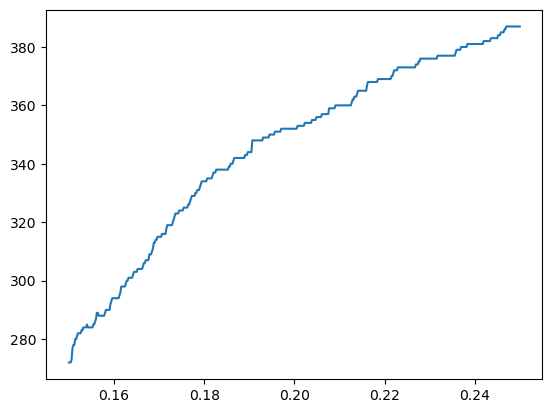

In [26]:
sum(abs(intersection[0])**2)

0.9999999933434083

In [185]:
best_decs=col_list[:19*19]
second_best_decs=col_list[19*19:19*19+19*19]
intersection=[]

for i in best_decs:
    for j in second_best_decs:
        if abs(np.inner(i,j.conj()))>0.98:
            intersection.append(i)
            break
print(len(intersection))

342


In [186]:
def get_max_avg(medium_hat):
    sum_max_inner_original=0
    medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max over hats
    index_list=[]
    for i in range(int(outdim*2)):
        if max(torch_inners[:, i])>.99 and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
    return index_list, max_avg_inners_original







inds, avg=get_max_avg(best_decs)
inds_2, avg_2=get_max_avg(second_best_decs)
len(inds), len(inds_2), avg, avg_2 ,len(set(inds).intersection(set(inds_2)))

(351, 347, 0.9925381510045287, 0.9913047515140315, 341)

In [187]:
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium_hat=best_decs
medium_hat2=second_best_decs
for i in range(len(medium_hat)):
    if np.allclose(medium.transpose()[0],medium_hat[i]):
        print(f'M1 all close at index {i}')
    if np.allclose(medium.transpose()[0],medium_hat2[i]):
        print(f'M2 all close at index {i}')
        
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
 

In [85]:
medium[0].shape,medium_hat[i].shape

((361,), (806,))

(351/361), (293/361)----> missed (10/361), (68/361)

In [188]:
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium_hat=best_decs
medium_hat2=second_best_decs
j=40
for i in range(len(medium_hat)):
    if abs(np.inner(medium.transpose()[j],medium_hat[i].conj()))>0.99:
        print(abs(np.inner(medium.transpose()[j], medium_hat[i].conj())))
        print(f'M1 all close at index {i}')
        M=medium_hat[i].conj()
    if abs(np.inner(medium.transpose()[j],medium_hat2[i].conj()))>.99:
        print(f'M2 all close at index {i}')
    #if np.allclose(medium.transpose()[5],medium_hat[i]):
    #    print(f'M1 all close at index {i}')
    #if np.allclose(medium.transpose()[0],medium_hat2[i]):
    #    print(f'M2 all close at index {i}')
        
#torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
abs(np.inner(medium_hat[17], medium_hat2[300].conj())), abs(np.inner(M.conj(), medium_hat[17].conj()))

M2 all close at index 117
0.9958233696544182
M1 all close at index 161


(0.009779493, 0.053249758)

In [155]:
abs(np.inner(medium_hat[300], medium_hat2[17].conj())), abs(np.inner(medium.transpose()[j], medium_hat[300].conj()))

(0.98949236, 0.9929563352907004)

In [190]:
abs(np.inner(medium_hat[161], medium_hat2[117].conj())), abs(np.inner(medium.transpose()[j], medium_hat[66].conj()))

(0.9895881, 0.06303961071433435)

In [152]:
M[:3], medium_hat[300][:3]

(array([-0.0231919 +0.04800251j, -0.01716773+0.03939999j,
        -0.00609548+0.02506872j], dtype=complex64),
 array([-0.0231919 -0.04800251j, -0.01716773-0.03939999j,
        -0.00609548-0.02506872j], dtype=complex64))

In [147]:
M.shape, medium_hat[17].shape

((806,), (806,))

shape of the union without removin: (18050, 806)


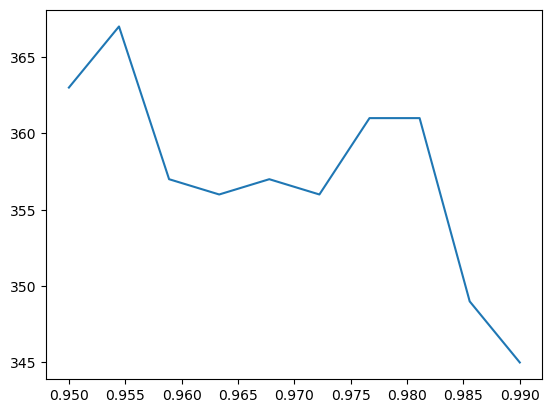

In [8]:
col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}')
size_list=[]
eps_lin=np.linspace(.95,.99,10)
for eps in eps_lin:
    intersection=[]
    intersection.append(col_list[0])

    for i in range(len(col_list)):
        in_flag=False
        repeated_flag=False
        for j in range(1,len(col_list)):
            j=(i+19*19+j)%(19*19)
            if abs(np.inner(col_list[i],col_list[j].conj()))>eps and i!=j:
                repeated_flag=True
                break
            else:
                repeated_flag=False
        for j in range(len(intersection)):
            if abs(np.inner(col_list[i],intersection[j].conj()))>eps:
                in_flag=True
                break
            else:
                in_flag=False
        if repeated_flag and (not in_flag):
            intersection.append(col_list[i])
    size_list.append(len(intersection))
        
plt.plot(eps_lin,size_list)

In [44]:
sum_max_inner_original=0
medium_hat=intersection
otherway=0
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
index_list=[]
for i in range(int(outdim*2)):
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
max_avg_inners_original=sum_max_inner_original/(int(outdim*2))

index_list_outs=[]
for i in range(int(outdim*2)):
    if max(torch_inners[:, i])<.95 and i not in index_list_outs:
        index_list_outs.append(i)
    

#lr_scheduler_enc.step()
#lr_scheduler_decod.step()
#sum_max_inner_original=0      
        #original way of computing inners
        # mean over true max over hats
maxG_inner_list=[max(torch_inners[:, i]) for i in range(int(outdim*2))]

max_avg_inners_original

0.9743225274336376

shape of the union without removin: (18050, 806)


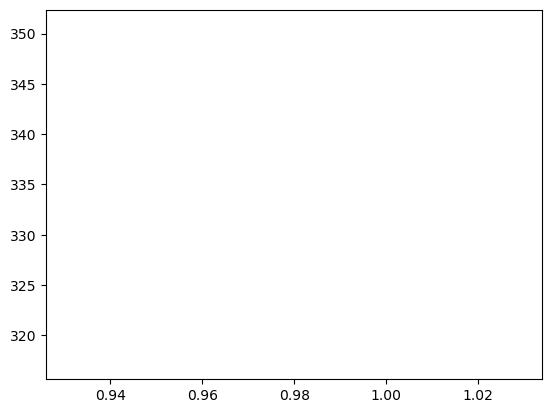

In [40]:
col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}')
size_list=[]
eps_lin=[.98, .985, .99, .991]
for eps in eps_lin:
    intersection=[]
    intersection.append(col_list[0])

    for i in range(len(col_list)):
        in_flag=False
        repeated_flag=False
        for j in range(1,len(col_list)):
            j=(i+19*19+j)%(19*19)
            if abs(np.inner(col_list[i],col_list[j].conj()))>eps and i!=j:
                repeated_flag=True
                break
            else:
                repeated_flag=False
        for j in range(len(intersection)):
            if abs(np.inner(col_list[i],intersection[j].conj()))>.8:
                in_flag=True
                break
            else:
                in_flag=False
        if repeated_flag and (not in_flag):
            intersection.append(col_list[i])
    size_list.append(len(intersection))
        
plt.plot(eps_lin,size_list)

In [41]:
size_list

[334]

In [17]:
intersection.shape
sum_max_inner_original=0
medium_hat=intersection
otherway=0
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
index_list=[]
for i in range(int(outdim*2)):
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
max_avg_inners_original=sum_max_inner_original/(int(outdim*2))

index_list_outs=[]
for i in range(int(outdim*2)):
    if max(torch_inners[:, i])<.95 and i not in index_list_outs:
        index_list_outs.append(i)
    

#lr_scheduler_enc.step()
#lr_scheduler_decod.step()
#sum_max_inner_original=0      
        #original way of computing inners
        # mean over true max over hats
maxG_inner_list=[max(torch_inners[:, i]) for i in range(int(outdim*2))]

 max_avg_inners_original

In [19]:
len(index_list)

31

0.9747579726564

In [38]:
col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
for k in range(361):
    G_i=medium.T[k]
    G_i_hats=[]

    for i in col_list:
        inn_list=abs(np.inner(G_i, i.conj()))
        if inn_list>.99:
            G_i_hats.append(i)
    #    num_times_recovered_list.append(num_times_recovered)
    G_i_hats=np.array(G_i_hats)
    G_i_hat_distanced=[np.sum(abs(G_i_hat-G_i)**2)**(1/2) for G_i_hat in G_i_hats]
    G_i_hat_inners=[abs(np.inner(G_i_hat, G_i.conj())) for G_i_hat in G_i_hats]
    G_i_hat_inners.sort()
    G_i_hat_distanced.sort()
    torch_inners=np.abs(np.inner(G_i_hats,G_i_hats.conj()) ) #entry i j is ghat_i dot bar(g_j) 
    min_inners=[min(torch_inners[i]) for i in range(len(G_i_hats))]
    min_inners.sort()
    if len(G_i_hats)<15:
        print(min_inners[:5], min_inners[-5:], len(min_inners))

[0.9978011, 0.9978011, 0.99780947, 0.9978536, 0.9978828] [0.99800396, 0.99837613, 0.99839664, 0.99876887, 0.99889874] 12
[0.99659824, 0.99659824, 0.99668086, 0.99670136, 0.99670404] [0.99670404, 0.9967123, 0.99680835, 0.99681234, 0.99694425] 9
[0.9977099, 0.9977099, 0.99771523, 0.99771553, 0.9977175] [0.99785423, 0.99797285, 0.9980465, 0.99828464, 0.998429] 14
[0.99692935, 0.99692935, 0.9969955, 0.9969955, 0.9970249] [0.99732107, 0.9974383, 0.997554, 0.9978738, 0.9985315] 12
[0.98679465, 0.98679465, 0.986889, 0.98743856, 0.990875] [0.9911077, 0.9911911, 0.99179655, 0.9921622, 0.99232394] 12
[0.9959373, 0.9959373, 0.9963674, 0.9963815, 0.9964518] [0.99734825, 0.99739665, 0.9975024, 0.9975119, 0.9976469] 13
[0.992789, 0.992789, 0.9937302, 0.99424493, 0.994246] [0.994618, 0.9948752, 0.99512047, 0.99582344, 0.9966915] 10


In [36]:
col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break
col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    num_rec=0
    for dumm in inn_list:
        if dumm>.99:
            num_rec=num_rec+1
    num_times_recovered_list.append(num_rec)
            
    #inn_list_max_list.append(np.max(inn_list))
    #num_times_recovered=len(inn_list[inn_list>.99])
    #num_times_recovered_list.append(num_times_recovered)

print(num_times_recovered_list.indexOf(9))
num_times_recovered_list=sorted(num_times_recovered_list)
num_times_recovered_list[:5]
plt.plot([i for i in range(361)], num_times_recovered_list)
print(num_times_recovered_list[:5])
#Take all the 50 dictionaries and through this process of finding outliers 

shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)


AttributeError: 'list' object has no attribute 'indexOf'

In [37]:
print(num_times_recovered_list.index(9))


44


(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)


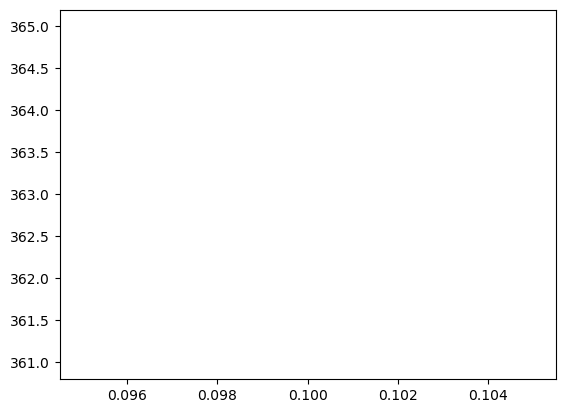

In [3]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN


%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
if False: #This vlock is from betas sweep. good betas. Not optimal.
    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_0_'
    timescampstrs={'07-14-29','09-46-07','14-35-38','13-49-42','09-45-53'} #they located in above or below
    #            curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]



if True:#This block is from tests done with all default (pytorch) parameters


    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
    timescampstrs = [
    "44_00-31-12",
    "47_00-31-10",
    "43_18-10-40",
    "46_18-10-39",
    "41_18-10-04",
    "49_18-00-09",
    "48_11-52-40",
    "45_11-50-38",
    "42_11-50-21",
    "40_11-49-46",
    "25_8-6-24",
    "24_01-54-27",
    "9_21-43-17",
    "4_21-42-58",
    "23_17-55-08",
    "29_15-29-37",
    "39_15-11-34",
    "34_15-09-31",
    "8_13-43-00",
    "3_13-42-41",
    "22_09-55-47",
    "38_08-50-47",
    "33_08-47-54",
    "28_08-46-30",
    "7_05-43-01",
    "2_05-42-47",
    "37_02-29-47",
    "32_2-26-51",
    "27_2-25-22",
    "21_01-56-27",
    "6_21-43-02",
    "1_21-42-47",
    "36_20-08-25",
    "31_20-05-29",
    "26_20-04-14",
    "20_17-57-14",
    "35_13-47-33",
    "30_13-44-32",
    "5_13-43-10",
    "0_13-42-53",
    "19_11-58-46",
    "18_8-27-31",
    "17_5-3-27",
    "16_01-39-09",
    "15_22-14-51",
    "14_17-34-09",
    "13_12-36-21",
    "12_9-12-21",
    "11_05-47-25",
    "10_1-9-58"
]

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'


decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        #print(medium_hat.shape)
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)


col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))
X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
num_clusters=[]
eps_linspace=np.linspace(.2,.7,50)
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))

for eps in eps_linspace:
    DBSCAN_fit=DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(torch_inner)

    DBSCAN_fit.labels_
    X_clustered=X[DBSCAN_fit.labels_!=-1]
    len(X_clustered)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    #dist_in_cluster=[]
    #for i in range(max(DBSCAN_fit.labels_)):
        #X_in_cluster=X[DBSCAN_fit.labels_==i]
        #dist_matrix=distance_matrix(X_in_cluster, X_in_cluster)
        #max_dist_in_cluster=np.max(dist_matrix)
        #dist=sum((X_in_cluster[0]-X_in_cluster[1])**2)**(1/2)
        #dist_in_cluster.append(max_dist_in_cluster)
    # if len(X[DBSCAN_fit.labels_==i])>1:
    #     dist_in_cluster.append(np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1))
    # else:
    #     dist_in_cluster.append(0)
    #dist_in_cluster#=[np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1)) for i in range(max(DBSCAN_fit.labels_))]
    #dist_in_cluster.sort()
    #plt.plot([i for i in range(len(dist_in_cluster))], dist_in_cluster)
    num_clusters.append(len(cluster_sizes))
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
plt.plot(eps_linspace, num_clusters, label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[0],eps_linspace[-1], colors='r', linestyles='dashed', label='True number of columns')

In [12]:
ghat_list=[]
for i in range(len(cluster_sizes)):
    if cluster_sizes[i]>4:
        ghat_list.append(X[DBSCAN_fit.labels_==i][0])

medium_hat=np.vstack(ghat_list)
medium_hat=H.cat2complex(medium_hat)   
print(medium_hat.shape)

torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=0)
print(max_inners[0],max(torch_inners[:,0]))
len(max_inners[max_inners>.99]),max_inners.mean()

(361, 806)
0.9998468939148394 0.9998468939148394


(327, 0.9887969974582396)

: 